In [76]:
from datetime import datetime 
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
sns.set(style='darkgrid', context='talk', palette='Dark2')
%matplotlib inline

### Observation of the S&P500

In [131]:
start_date = datetime(2015,1,1)
end_date = datetime(2019,1,1)
sp500 = web.DataReader("^GSPC", "yahoo", start_date, end_date)
sp500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,2072.360107,2046.040039,2058.899902,2058.199951,2708700000,2058.199951
2015-01-05,2054.439941,2017.339966,2054.439941,2020.579956,3799120000,2020.579956
2015-01-06,2030.250000,1992.439941,2022.150024,2002.609985,4460110000,2002.609985
2015-01-07,2029.609985,2005.550049,2005.550049,2025.900024,3805480000,2025.900024
2015-01-08,2064.080078,2030.609985,2030.609985,2062.139893,3934010000,2062.139893


In [10]:
sp_close = sp500['Close']
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
sp_close = sp_close.reindex(all_weekdays)
sp_close = sp_close.fillna(method='ffill')
sp_close.describe()

count    1043.000000
mean     2337.070212
std       295.700022
min      1829.079956
25%      2087.190063
50%      2265.199951
75%      2629.420044
max      2930.750000
Name: Close, dtype: float64

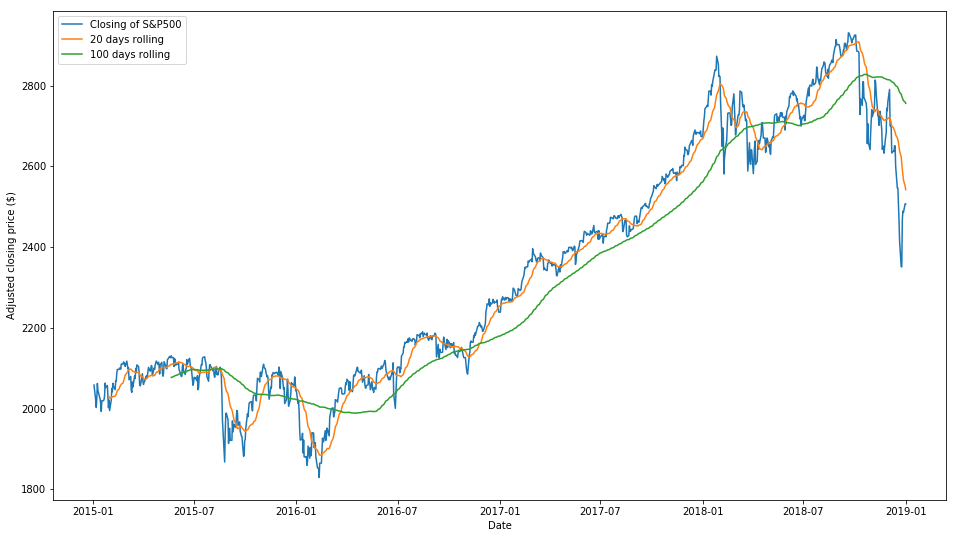

In [12]:
short_rolling = sp_close.rolling(window=20).mean()
long_rolling = sp_close.rolling(window=100).mean()

fig, ax = plt.subplots(figsize=(16,9))

plt.plot(sp_close.index, sp_close, label='Closing of S&P500')
ax.plot(short_rolling.index, short_rolling, label='20 days rolling')
ax.plot(long_rolling.index, long_rolling, label='100 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

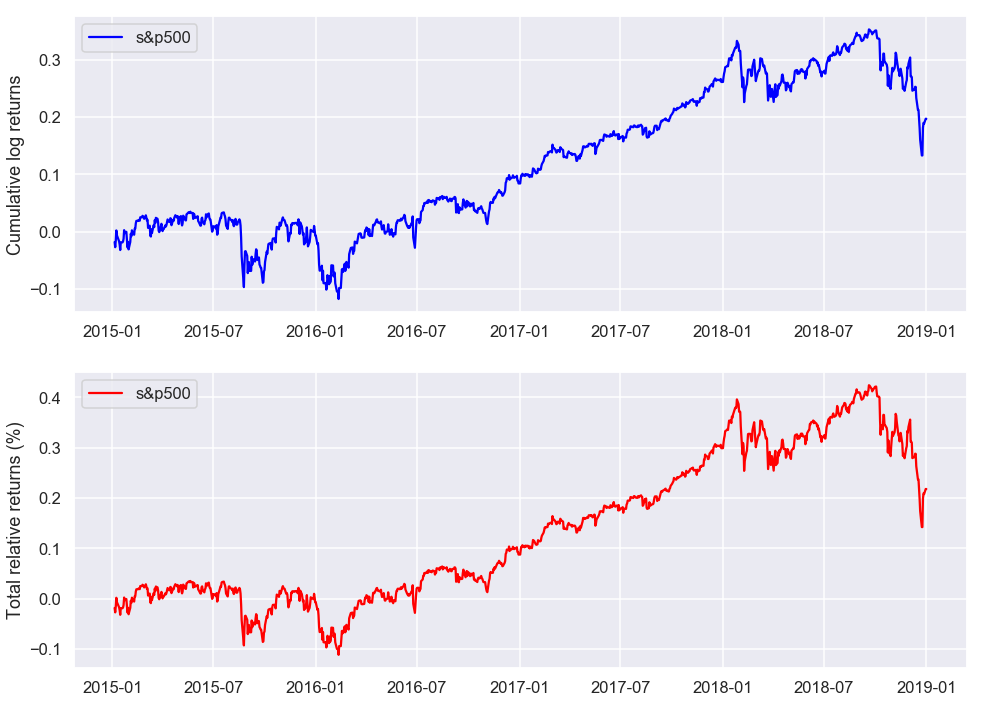

In [35]:
returns = sp_close.pct_change(1)
log_returns = np.log(sp_close).diff()
log_returns = log_returns.dropna()



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))


ax1.plot(log_returns.index, log_returns.cumsum(), label=str('s&p500'), color = 'blue')

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')


ax2.plot(log_returns.index, (np.exp(log_returns.cumsum()) - 1), label=str('s&p500'), color = 'red')

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()

### Portfolio

In [45]:
stocks = web.DataReader(['AAPL','GOOGL', 'AMZN'], "yahoo", start_date, end_date)
stocks = stocks['Close']
stocks = stocks.fillna(method='ffill')
stocks = stocks.dropna()

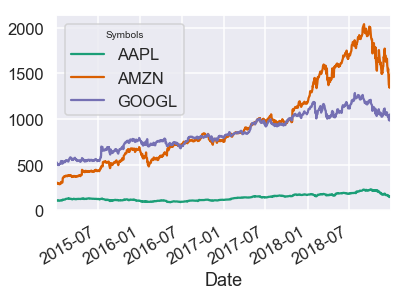

In [47]:
stocks.plot()

In [49]:
weights_matrix = pd.DataFrame(1 / 3, index=stocks.index, columns=stocks.columns)
weights_matrix.tail()

Symbols,AAPL,AMZN,GOOGL
Date,,,
2018-12-24,0.333333,0.333333,0.333333
2018-12-26,0.333333,0.333333,0.333333
2018-12-27,0.333333,0.333333,0.333333
2018-12-28,0.333333,0.333333,0.333333
2018-12-31,0.333333,0.333333,0.333333


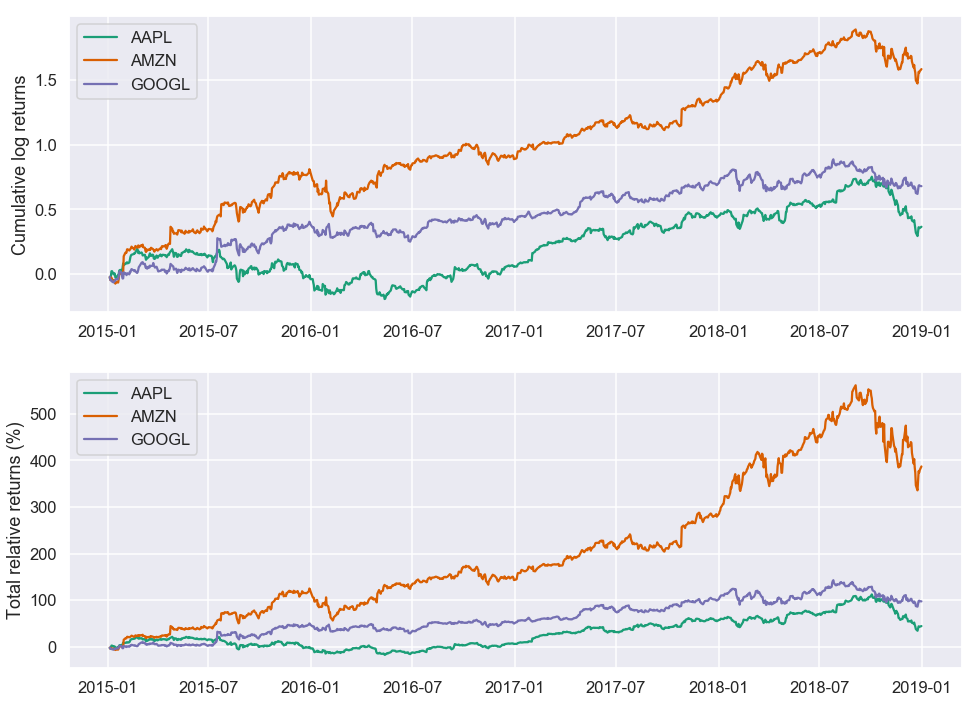

In [51]:
log_returns = np.log(stocks).diff()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()

In [60]:
r_t = log_returns.tail(1).transpose()
print('r_t: \n',r_t, '\n')
weights_vector = pd.DataFrame(1 / 3, index=r_t.index, columns=r_t.columns)
print('weights: \n',weights_vector, '\n')
portfolio_log_return = weights_vector.transpose().dot(r_t)
portfolio_log_return

r_t: 
 Date     2018-12-31
Symbols            
AAPL       0.009619
AMZN       0.016074
GOOGL     -0.001645 

weights: 
 Date     2018-12-31
Symbols            
AAPL       0.333333
AMZN       0.333333
GOOGL      0.333333 



Date,2018-12-31 00:00:00
Date,
2018-12-31,0.008016


In [66]:
weights_matrix = pd.DataFrame(1 / 3, index=stocks.index, columns=stocks.columns)
temp_var = weights_matrix.dot(log_returns.transpose())
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.head()

Date
2015-01-02         NaN
2015-01-05   -0.022848
2015-01-06   -0.015998
2015-01-07    0.007174
2015-01-08    0.015998
dtype: float64

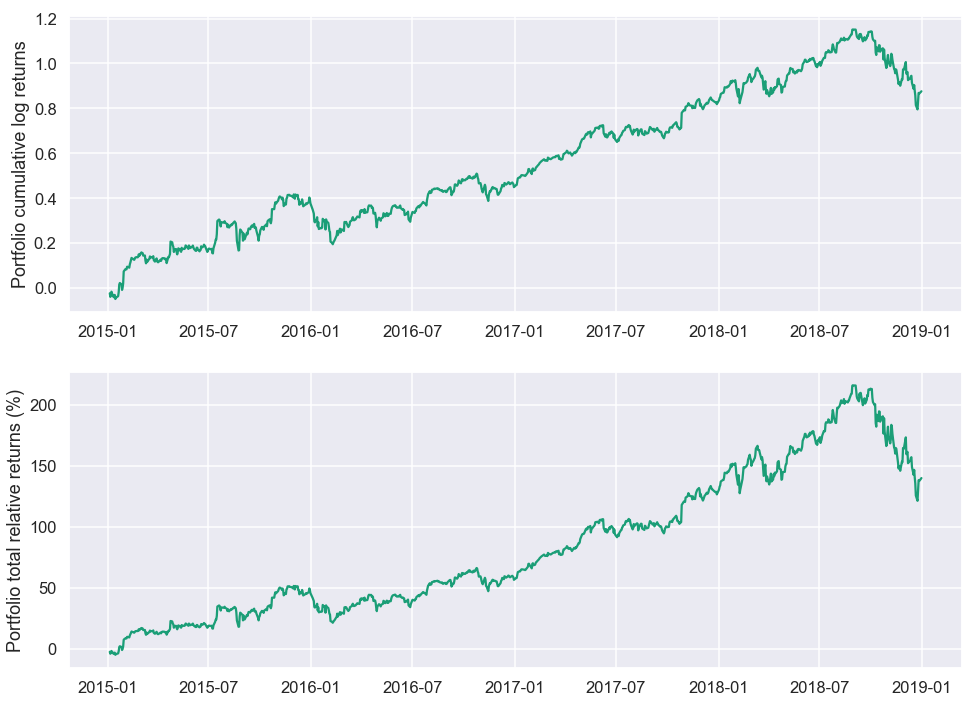

Total portfolio return is: 140.21%
Average yearly return is: 25.42%


In [71]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100 * total_relative_returns)
ax2.set_ylabel('Portfolio total relative returns (%)')

plt.show()


#return: 

days_per_year = 52 * 5
total_days_in_simulation = stocks.shape[0]
number_of_years = total_days_in_simulation / days_per_year

# The last data point will give us the total portfolio return
total_portfolio_return = total_relative_returns[-1]
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%')

In [72]:
short_rolling = stocks.rolling(window=20).mean()
long_rolling = stocks.rolling(window=100).mean()

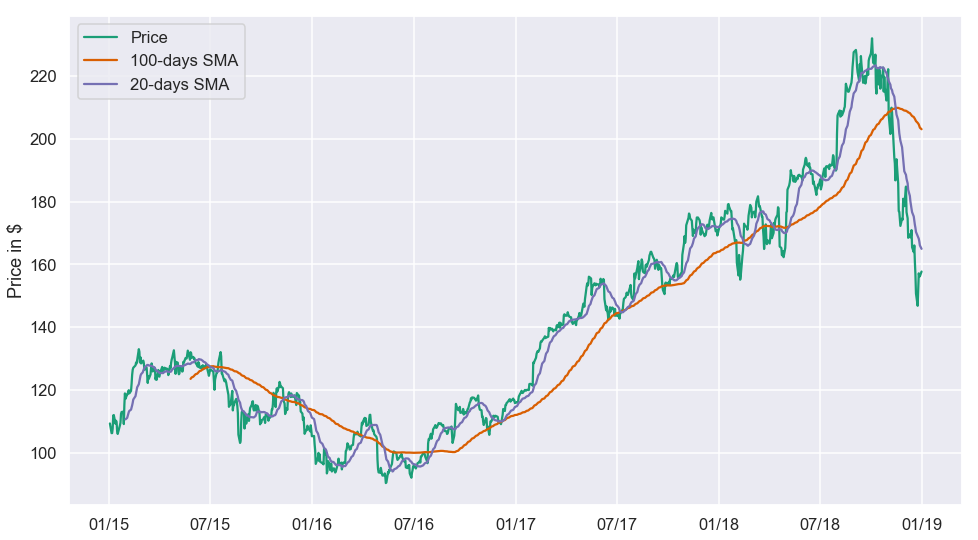

In [77]:
fig, ax = plt.subplots(figsize=(16,9))

my_year_month_fmt = mdates.DateFormatter('%m/%y')

ax.plot(stocks.loc[start_date:end_date, :].index, stocks.loc[start_date:end_date, 'AAPL'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

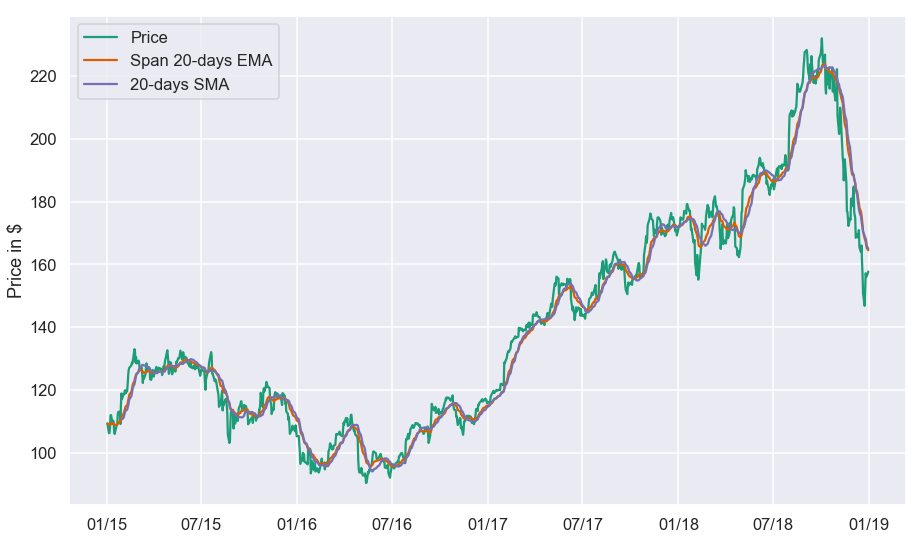

In [78]:
ema_short = stocks.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(stocks.loc[start_date:end_date, :].index, stocks.loc[start_date:end_date, 'AAPL'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'AAPL'], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [177]:
trading_positions_raw = stocks - ema_short
#trading_positions_raw = stocks - short_rolling`
#trading_positions_raw = stocks - long_rolling
trading_positions_raw.describe()

Symbols,AAPL,AMZN,GOOGL
count,1006.000000,1006.000000,1006.000000
mean,0.521442,11.536510,4.871177
std,5.015080,39.913540,24.397782
min,-23.471222,-236.260910,-106.848687
25%,-1.747099,-1.618849,-7.899693
50%,0.941981,13.151666,4.917296
75%,3.350717,30.021058,19.232298
max,14.260786,128.197070,125.010995


In [185]:
trading_positions_final = trading_positions_raw.div(trading_positions_raw.abs().sum(axis=1), axis=0)
#trading_positions_final = 1/3 * trading_positions_raw.apply(np.sign)
#trading_positions_final = trading_positions_final.shift(1)
trading_positions_final.describe()

Symbols,AAPL,AMZN,GOOGL
count,1005.000000,1005.000000,1005.000000
mean,0.017179,0.259633,0.084655
std,0.139447,0.496483,0.423260
min,-0.684851,-0.941909,-0.977064
25%,-0.050789,-0.105917,-0.289432
50%,0.025838,0.461285,0.201378
75%,0.085705,0.619135,0.416081
max,0.657912,0.968696,0.958953


In [186]:
trading_positions_final.loc[np.abs(trading_positions_final.AAPL) <= 0.13, 'AAPL'] = 0
trading_positions_final.loc[np.abs(trading_positions_final.AMZN) <= 0.49, 'AMZN'] = 0
trading_positions_final.loc[np.abs(trading_positions_final.GOOGL) <= 0.42, 'GOOGL'] = 0

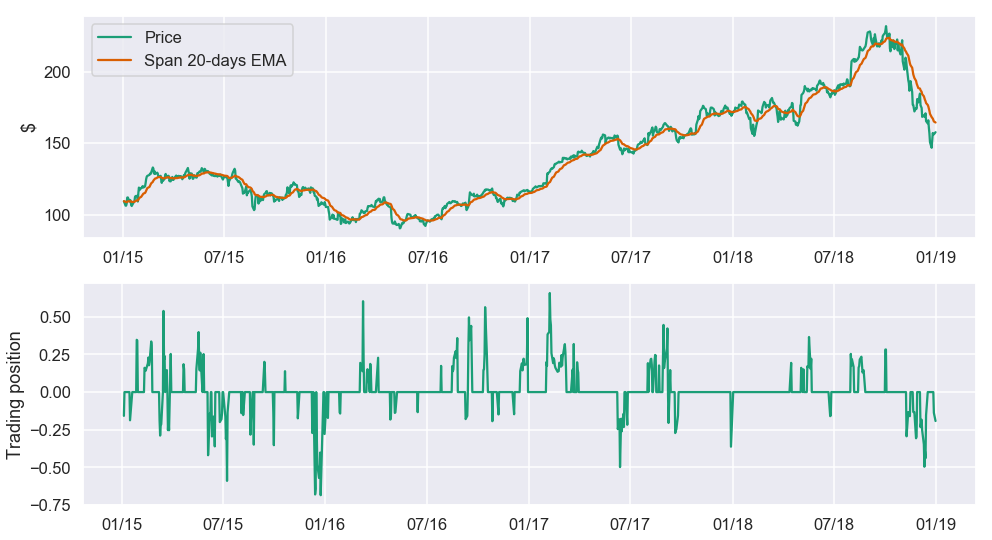

In [187]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(stocks.loc[start_date:end_date, :].index, stocks.loc[start_date:end_date, 'AAPL'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'AAPL'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'AAPL'], 
        label='Trading position')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [188]:
asset_log_returns = np.log(stocks).diff()
asset_log_returns.head()

Symbols,AAPL,AMZN,GOOGL
Date,,,
2015-01-02,NaN,NaN,NaN
2015-01-05,-0.028576,-0.020731,-0.019238
2015-01-06,0.000094,-0.023098,-0.024989
2015-01-07,0.013925,0.010544,-0.002945
2015-01-08,0.037703,0.006813,0.003478


In [189]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

Symbols,AAPL,AMZN,GOOGL
Date,,,
2018-12-24,-0.000000,0.017790,-0.0
2018-12-26,0.000000,-0.076701,0.0
2018-12-27,-0.000000,0.005140,0.0
2018-12-28,-0.000071,-0.009391,-0.0
2018-12-31,-0.001848,-0.012795,-0.0


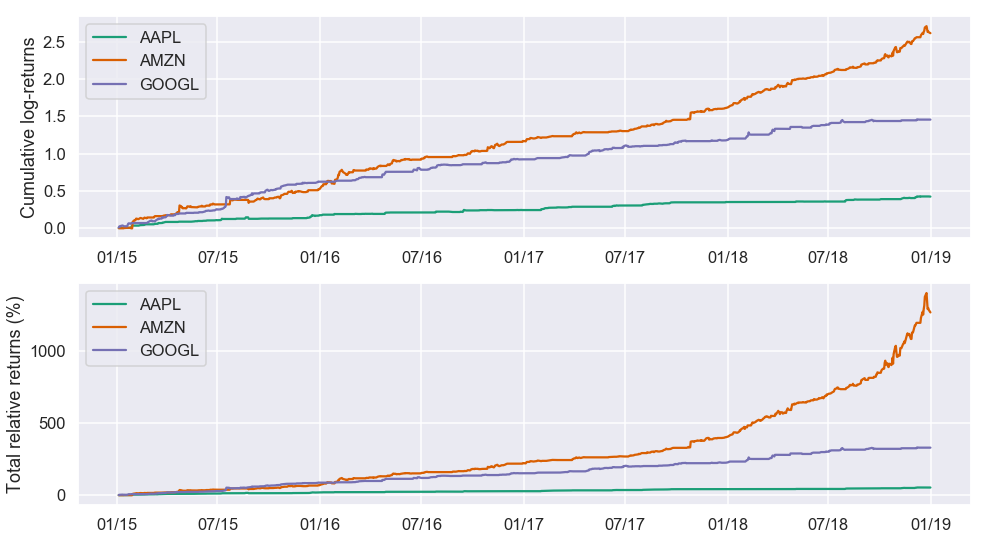

In [190]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

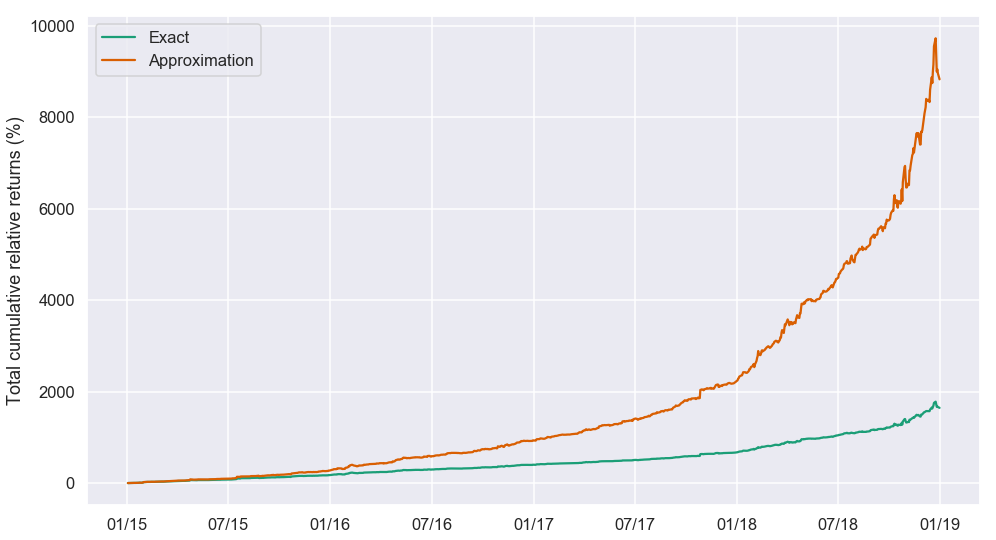

In [191]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

Total portfolio return is: 1645.01%
Average yearly return is: 109.38%
Total portfolio return is: 107.91%
Average yearly return is: 20.82%


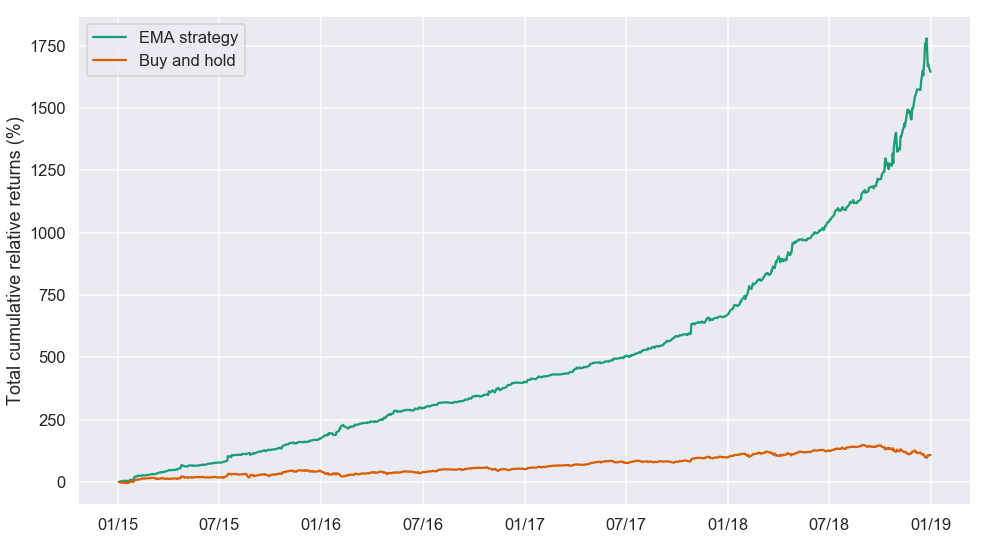

In [193]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)



# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = stocks.index, columns=stocks.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)
